# Linear Regression with multiple variables

We will be predicting house prices given Boston house prices dataset.

## 0 - Download data ##

In [1]:
!pip install wget
import wget
wget.download("https://dru.fra1.digitaloceanspaces.com/DS_Fundamentals/datasets/04_supervised_learning/Linear_Regression_with_multiple_variables/boston_house_prices.csv")

100% [..............................................................................] 35200 / 35200

'boston_house_prices (7).csv'

## 1 - Packages ##

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 2 - Overview of the Dataset ##



Boston House Prices dataset
===========================

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
    - PTRATIO  pupil-teacher ratio by town
    - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    - LSTAT    % lower status of the population
    - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/


This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
**References**

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.
   - many more! (see https://archive.ics.uci.edu/ml/machine-learning-databases/housing/)





<b>Let's get more familiar with the dataset. Load the data by running the following code.</b>


In [3]:
# Loading the data
boston_df = pd.read_csv("boston_house_prices.csv", sep=';')
features = boston_df.loc[:, boston_df.columns != 'MEDV'].to_numpy()
target = boston_df.loc[:, boston_df.columns == 'MEDV'].to_numpy()

def load_data(features, target):
    from sklearn.model_selection import train_test_split

    train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(features, target, test_size=0.33, random_state=42)

    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))

    return train_set_x.T, train_set_y, test_set_x.T, test_set_y

train_set_x, train_set_y, test_set_x, test_set_y = load_data(features, target)

In [4]:
print(train_set_x.shape, train_set_y.shape, test_set_x.shape, test_set_y.shape)

(13, 339) (1, 339) (13, 167) (1, 167)


Many software bugs in machine learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

In [5]:
m_train = train_set_x.shape[1]
m_test = test_set_x.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))

print ("\ntrain_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 339
Number of testing examples: m_test = 167

train_set_x shape: (13, 339)
train_set_y shape: (1, 339)
test_set_x shape: (13, 167)
test_set_y shape: (1, 167)


### Data visualization

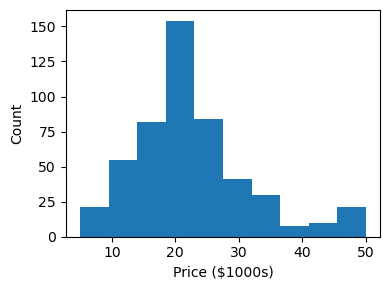

In [6]:
plt.figure(figsize=(4, 3))
plt.hist(target)
plt.xlabel("Price ($1000s)")
plt.ylabel("Count")
plt.tight_layout()

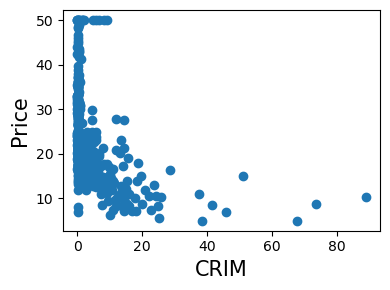

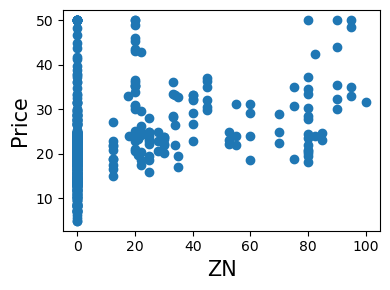

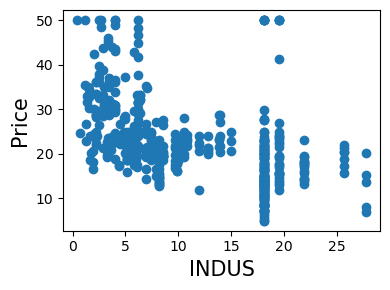

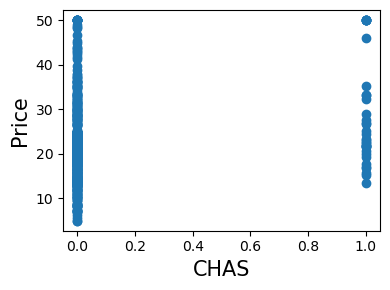

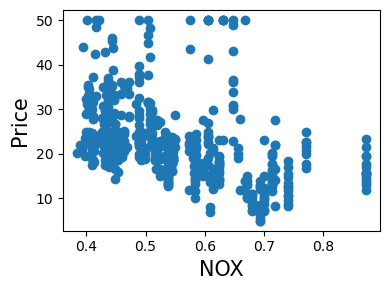

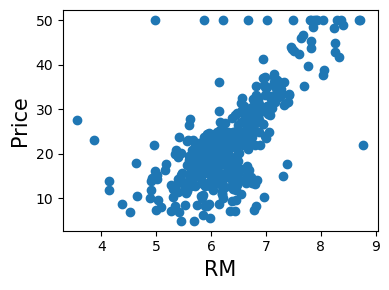

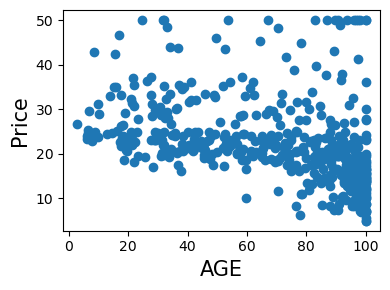

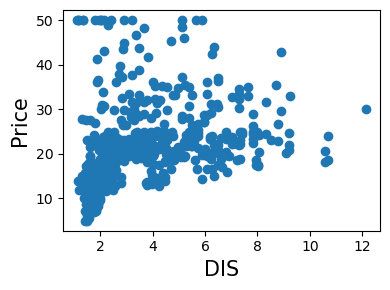

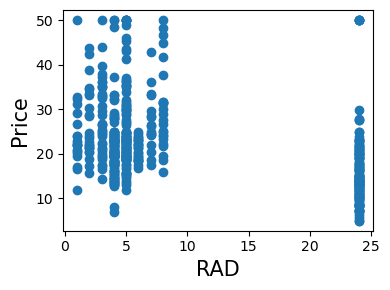

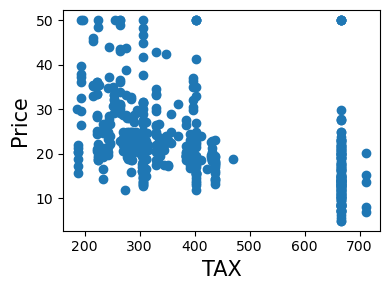

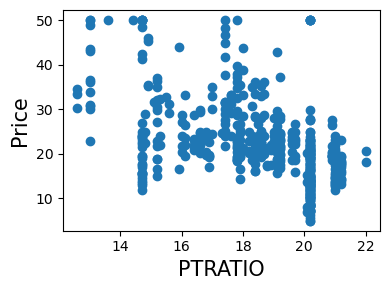

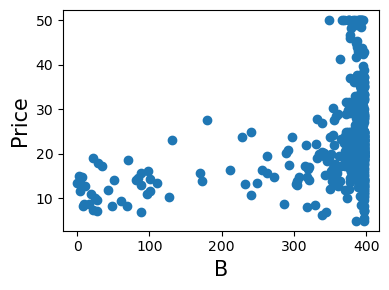

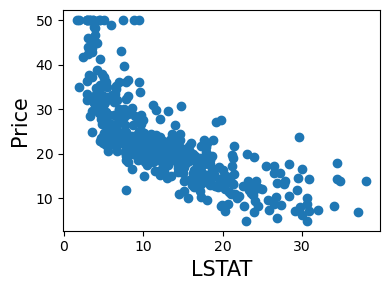

In [7]:
for index, feature_name in enumerate(boston_df.columns[:-1]):
    plt.figure(figsize=(4, 3))
    plt.scatter(features[:, index], target)
    plt.ylabel("Price", size=15)
    plt.xlabel(feature_name, size=15)
    plt.tight_layout()

### Standardization

$$X_{new} = \frac{X - \mu}{\sigma}$$

Let's standardize our dataset.

In [8]:
all_set_x = np.concatenate([train_set_x, test_set_x], axis=1)

mean = all_set_x.mean(axis=1, keepdims=True)
std = all_set_x.std(axis=1, keepdims=True)

train_set_x = (train_set_x - mean) / std
test_set_x = (test_set_x - mean) / std

## 3 - General Architecture of the learning algorithm ##

**Mathematical expression of the algorithm**:


For one example $x^{(i)}$:
$$h^{(i)} =  w^T x^{(i)} + b \tag{1}$$

The cost is then computed by summing squared diff over all training examples:
$$J = \frac{1}{2m}\sum_{i=1}^{m}(h^{(i)} - y^{(i)})^{2}\tag{2}$$

## 4 - Building the parts of our algorithm ## 

The main steps for building a learning algorithm:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Initializing parameters

In [9]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
   
    w = np.zeros((dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [10]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### 4.2 - Forward and Backward propagation

Forward Propagation:
- You get X
- You compute $H = (w^T X + b) = (h^{(1)}, h^{(2)}, ..., h^{(m-1)}, h^{(m)})$
- You calculate the cost function: $J = \frac{1}{2m}\sum_{i=1}^{m}(h^{(i)} - y^{(i)})^{2}$


Here is the formula of gradient of the cost function: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(H-Y)^T\tag{3}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (h^{(i)}-y^{(i)})\tag{4}$$


In [11]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (number of features, 1)
    b -- bias, a scalar
    X -- data of shape (number of features, number of examples)
    Y -- results of shape (1, number of examples)
    
    Return:
    cost -- cost function for linear regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation.
    - Use np.dot() to avoid for-loops in favor of code vectorization
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    H = np.dot(w.T,X) + b    # compute activation
    cost = (1/(2*m)*np.sum((H-Y)**2)) # compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1/m)*np.dot(X, (H-Y).T)
    db = (1/m)*np.sum(H-Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [12]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[12.8       ]
 [30.82666667]]
db = 4.533333333333333
cost = 41.49333333333333


### 4.3 - Optimization
The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } \partial\theta$, where $\alpha$ is the learning rate.

In [13]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (number of features, 1)
    b -- bias, a scalar
    X -- data of shape (number of features, number of examples)
    Y -- results of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1 line of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w -= learning_rate * dw
        b -= learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [14]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[-0.04675219]
 [-0.12676061]]
b = 1.223758731602527
dw = [[ 0.12274692]
 [-0.09406359]]
db = 0.36833971156600487


Calculate $H = w^T X + b$

In [15]:
def predict(w, b, X):
    """
    Predict using learned linear regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (number of features, 1)
    b -- bias, a scalar
    X -- data of shape (number of features, number of examples)
    
    Returns:
    H -- a numpy array (vector) containing all predictions for the examples in X
    """
    
    m = X.shape[1]
    
    # Compute vector "H"
    H = np.dot(w.T, X) + b
    
    assert(H.shape == (1, m))
    
    return H

In [16]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[ 0.0897392   0.03843181 -0.6367585 ]]


## 5 - Merge all functions into a model ##


In [17]:
print(len(test_set_y))

1


In [18]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=3000, learning_rate=0.5, print_cost=False):
    """
    Builds the linear regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (number of features, m_train)
    Y_train -- training values represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (number of features, m_test)
    Y_test -- test values represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """

    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(len(X_train))

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print ("Train RMSE: {} ".format(np.sqrt(np.mean((Y_prediction_train - Y_train) ** 2))))
    print ("Test RMSE: {} ".format(np.sqrt(np.mean((Y_prediction_test - Y_test) ** 2))))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [19]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=3000, learning_rate=0.05, print_cost=True)

Cost after iteration 0: 307.900929
Cost after iteration 100: 11.793240
Cost after iteration 200: 11.585346
Cost after iteration 300: 11.532792
Cost after iteration 400: 11.512307
Cost after iteration 500: 11.502701
Cost after iteration 600: 11.497843
Cost after iteration 700: 11.495317
Cost after iteration 800: 11.493990
Cost after iteration 900: 11.493291
Cost after iteration 1000: 11.492921
Cost after iteration 1100: 11.492726
Cost after iteration 1200: 11.492623
Cost after iteration 1300: 11.492569
Cost after iteration 1400: 11.492540
Cost after iteration 1500: 11.492525
Cost after iteration 1600: 11.492517
Cost after iteration 1700: 11.492513
Cost after iteration 1800: 11.492510
Cost after iteration 1900: 11.492509
Cost after iteration 2000: 11.492509
Cost after iteration 2100: 11.492508
Cost after iteration 2200: 11.492508
Cost after iteration 2300: 11.492508
Cost after iteration 2400: 11.492508
Cost after iteration 2500: 11.492508
Cost after iteration 2600: 11.492508
Cost after i

### Predicted vs True visualization 

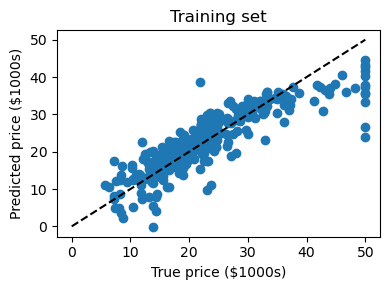

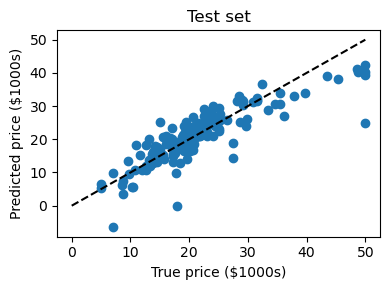

In [20]:
# Training set
plt.figure(figsize=(4, 3))
plt.title("Training set")
plt.scatter(train_set_y, d["Y_prediction_train"])
plt.plot([0, 50], [0, 50], "--k")
plt.axis("tight")
plt.xlabel("True price ($1000s)")
plt.ylabel("Predicted price ($1000s)")
plt.tight_layout()

# Test set
plt.figure(figsize=(4, 3))
plt.title("Test set")
plt.scatter(test_set_y, d["Y_prediction_test"])
plt.plot([0, 50], [0, 50], "--k")
plt.axis("tight")
plt.xlabel("True price ($1000s)")
plt.ylabel("Predicted price ($1000s)")
plt.tight_layout()

**Interpretation**:
You can see that in fact there is nice linear dependecy between predicted and true values.